In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%pylab inline

train = pd.read_csv('../data/train.csv')

train.drop(['HouseStyle','BldgType','GarageCars','Utilities'], axis=1, inplace=True)

cut_out=train.columns[train.count().values<0.1*len(train)].tolist()
train.drop(cut_out,axis=1,inplace=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
fix1=train[train.Exterior2nd=='Brk Cmn'].index.tolist()
train.loc[fix1,'Exterior2nd']='BrkComm'

fix2=train[train.Exterior2nd=='Wd Shng'].index.tolist()
train.loc[fix2,'Exterior2nd']='WdShing'

fix3=train[train.Exterior2nd=='CmentBd'].index.tolist()
train.loc[fix3,'Exterior2nd']='CemntBd'

train['Diff_in_Ext']=train.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)
train.drop('Exterior2nd',axis=1,inplace=True)

In [3]:
map_overall_to_cat={10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',
                    3:'Fair',2:'Poor',1:'Very Poor'}

train.OverallCond=train.OverallCond.map(map_overall_to_cat)
train.OverallQual=train.OverallQual.map(map_overall_to_cat)

cat_c=[]
for c in train.columns.tolist():
    if train[c].dtypes=='int64' or train[c].dtypes=='float64':
        continue
    else:
        cat_c.append(c)
cat_c.remove('MSZoning')

In [4]:
def make_dummies_conditional_on_len(train,c):
    df=train.groupby(c).Id.count()
    for i in df.index.tolist():
        if df.loc[i]>=50:
            name=str(c)+'_'+str(i)
            train[name]=np.where(train[c]==i,1,0)
    train.drop(c,axis=1, inplace=True)

for c in cat_c:
    make_dummies_conditional_on_len(train,c)

train.drop(['SaleType_New', 'CentralAir_Y','LandSlope_Gtl' ,'BsmtFinType2_Unf',
            'Foundation_PConc','RoofStyle_Gable', 'PavedDrive_Y','Electrical_SBrkr'], axis=1,inplace=True)


train.shape

(1460, 135)

In [6]:
LotFrontage_to_fix=train[train.LotFrontage.isnull()].index.tolist()
train.loc[LotFrontage_to_fix,'LotFrontage']=train.LotFrontage.mean()

MasVnrArea_to_fix=train[train.MasVnrArea.isnull()].index.tolist()
train.loc[MasVnrArea_to_fix,'MasVnrArea']=0

GarageYrBlt_to_fix=train[train.GarageYrBlt.isnull()].index.tolist()
train.loc[GarageYrBlt_to_fix,'GarageYrBlt']=train.GarageYrBlt.mean().round(0)

def turn_MS_data_into_cat(df):
    for i in df.MSSubClass.unique().tolist():
        for j in df.MSZoning.unique().tolist():
            if df[(df.MSSubClass==i)&(df.MSZoning==j)].Id.count()>=20:
                name=str(i)+'_'+str(j)
                df[name]=np.where((df.MSSubClass==i)&(df.MSZoning==j),1,0)
    df.drop(['MSSubClass','MSZoning'], axis=1, inplace=True)
turn_MS_data_into_cat(train)

train.drop('YearBuilt', axis=1, inplace=True)

train.loc[train[train.YearRemodAdd>train.YrSold].index,'YearRemodAdd']=2007

train['Avg_room_size']=train.GrLivArea/train.TotRmsAbvGrd

In [7]:
train=pd.concat([train,pd.get_dummies(train.BedroomAbvGr, prefix="br")], axis=1)
train.drop('br_8', axis=1, inplace=True)

In [32]:
train.drop(['MoSold', 'YrSold','SalePrice', 'Id'], axis=1,inplace=True)
train.shape

(1460, 152)

# checking for hige correletion

look here for more information:
https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels

In [33]:
m=train.corr()

In [46]:
w, v = np.linalg.eig(m)
eigen_values=pd.Series(w,index=range(len(train.columns)))
eigen_vectors=pd.DataFrame(v,index=range(len(train.columns)), columns=range(len(train.columns)))

In [47]:
eigen_values[eigen_values<0.01]


64     8.653384e-03
67     9.273408e-03
86     5.023367e-04
149    1.992895e-15
150   -5.538079e-15
151   -8.156801e-15
dtype: float64

i'll start investigating from "151" with the smallest eigen values

In [56]:
highly_corr=eigen_vectors[eigen_vectors[151]>0.3].index.tolist()

In [58]:
train.iloc[:,highly_corr].columns

Index(['br_1', 'br_2', 'br_3', 'br_4'], dtype='object')

In [59]:
highly_corr2=eigen_vectors[eigen_vectors[150]>0.3].index.tolist()

train.iloc[:,highly_corr2].columns

Index(['BsmtFinSF1', 'BsmtUnfSF'], dtype='object')

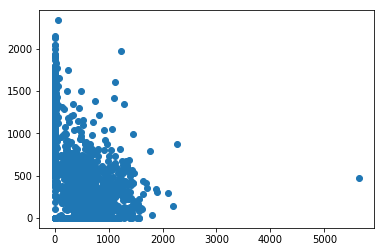

In [60]:
plt.scatter(train.BsmtFinSF1, train.BsmtUnfSF)

In [61]:
highly_corr3=eigen_vectors[eigen_vectors[149]>0.3].index.tolist()
train.iloc[:,highly_corr3].columns

Index(['1stFlrSF', '2ndFlrSF'], dtype='object')

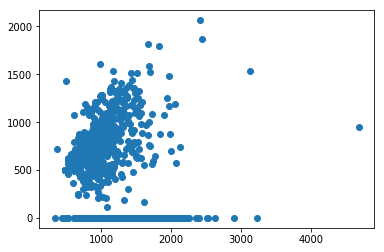

In [64]:
plt.scatter(train['1stFlrSF'], train['2ndFlrSF'] )

In [65]:
highly_corr4=eigen_vectors[eigen_vectors[86]>0.3].index.tolist()
train.iloc[:,highly_corr4].columns

Index(['BsmtFinType1_ALQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf'], dtype='object')

In [67]:
highly_corr5=eigen_vectors[eigen_vectors[67]>0.2].index.tolist()
train.iloc[:,highly_corr5].columns

Index(['GarageType_Attchd', 'GarageType_Detchd'], dtype='object')

In [69]:
highly_corr6=eigen_vectors[eigen_vectors[64]>0.1].index.tolist()
train.iloc[:,highly_corr6].columns

Index(['GarageType_Attchd', 'br_3', 'br_4', 'br_5', 'br_6'], dtype='object')

# Missions

1. making a variable- is there a basement. if there is do dimension reduction to 'BsmtFinSF1' and 'BsmtUnfSF'.
2. making a variable- is there a 2ndfloor. if there is do dimension reduction to '1stFlrSF' and '2ndFlrSF'.
3. check corr between 1stflrsf and lot size. or abvground area and lot size

# 1

In [70]:
train.columns.tolist()

['LotFrontage',
 'LotArea',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'Diff_in_Ext',
 'Street_Pave',
 'LotShape_IR1',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'Neighborhood_BrkSide',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition2_Norm

In [81]:
np.corrcoef(train.BsmtFinSF1, train.BsmtUnfSF)

array([[ 1.        , -0.49525147],
       [-0.49525147,  1.        ]])

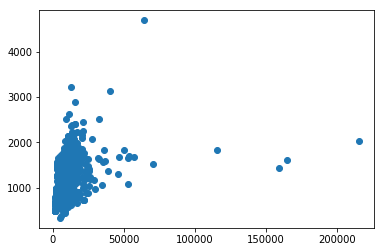

In [79]:
plt.scatter(train.LotArea,train['1stFlrSF'])

In [82]:
np.corrcoef(train.LotArea,train['1stFlrSF'])

array([[1.        , 0.29947458],
       [0.29947458, 1.        ]])

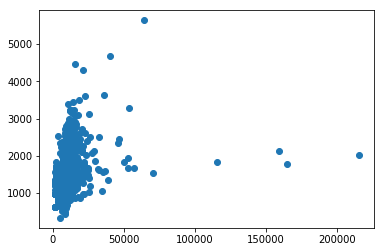

In [80]:
plt.scatter(train.LotArea,train['GrLivArea'])

In [83]:
np.corrcoef(train.LotArea,train['GrLivArea'])

array([[1.        , 0.26311617],
       [0.26311617, 1.        ]])

In [87]:
np.corrcoef(train['TotalBsmtSF'],train['1stFlrSF'])

array([[1.        , 0.81952998],
       [0.81952998, 1.        ]])